<a href="https://colab.research.google.com/github/KoniHD/hw2/blob/main/src/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Download Data

In [3]:
# Fetch data
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/test/Elmar_Brok_21.jpg  
  inflating: data/test/Elmar_Brok_30.jpg  
  inflating: data/test/Elmar_Brok_31.jpg  
  inflating: data/test/Elsa_Zylberstein_00.jpg  
  inflating: data/test/Elsa_Zylberstein_01.jpg  
  inflating: data/test/Elsa_Zylberstein_10.jpg  
  inflating: data/test/Elsa_Zylberstein_11.jpg  
  inflating: data/test/Elsa_Zylberstein_40.jpg  
  inflating: data/test/Elsa_Zylberstein_41.jpg  
  inflating: data/test/Elton_John_10.jpg  
  inflating: data/test/Elton_John_11.jpg  
  inflating: data/test/Elton_John_20.jpg  
  inflating: data/test/Elton_John_21.jpg  
  inflating: data/test/Elton_John_30.jpg  
  inflating: data/test/Elton_John_31.jpg  
  inflating: data/test/Elton_John_40.jpg  
  inflating: data/test/Elton_John_41.jpg  
  inflating: data/test/Emile_Lahoud_00.jpg  
  inflating: data/test/Emile_Lahoud_01.jpg  
  inflating: data/test/Emile_Lahoud_30.jpg  
  inflating: data/test/Emile_Lahoud_31.jpg  
  

## Setup Environment

Download the model code.

In [1]:
# FIXME: Necessary but not nice. Do imports better!
!git clone https://github.com/KoniHD/hw2.git
!mv hw2/src/* .
!rm -rf hw2 __init__.py hw2.ipynb

Cloning into 'hw2'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 39 (delta 17), reused 25 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 13.93 KiB | 2.32 MiB/s, done.
Resolving deltas: 100% (17/17), done.


Add necessary dependencies.

In [2]:
# No need if you are using colab

# !pip install matplotlib~=3.5.2
# !pip install scikit-image==0.19.2
# !pip install torch~=1.8.1
# !pip install torchvision~=0.9.1
# !pip install numpy~=1.21.6
# !pip install pillow~=9.1.1
# !pip install tqdm~=4.64.0
# !pip install jupyter==1.0.0
# !pip install opencv-python==4.6.0.66
# !pip install pandas==1.3.5
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 22.9 MB/s eta 0:00:00


Import required libraries and configure enviromnet.

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from tqdm import tqdm

import logging


from lightning.pytorch import Trainer, seed_everything
seed_everything(42, workers=True)   # Try to create deterministic results

# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset

from model import Simple_CNN
from keypoint_task import KeypointDetection

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


## Visualize the Data

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/to

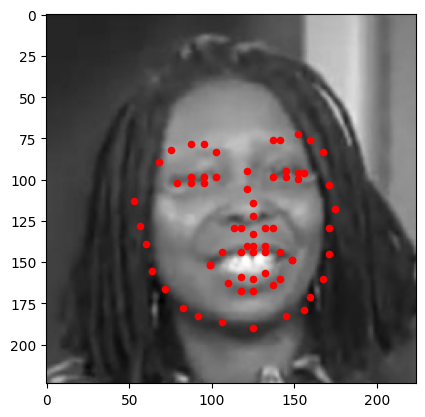

Image min/max:   0.0003 / 0.0038


In [2]:
# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)

# load training data in batches
batch_size = 16
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform
)

# loading test data in batches
batch_size = 16
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image black and white
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    plt.show()
    print(f"Image min/max:   {image.min():.4f} / {image.max():.4f}")
    break

# Sanity checks

In [4]:
import matplotlib
print(matplotlib.__version__)

# Pick one specific image directly
sample_path = "data/training/" + transformed_dataset.key_pts_frame.index[0]
print(f"Loading: {sample_path}")

# Load with mpimg
img_mpimg = mpimg.imread(sample_path)
print(f"\nmpimg.imread:")
print(f"  dtype: {img_mpimg.dtype}")
print(f"  min/max: {img_mpimg.min():.4f} / {img_mpimg.max():.4f}")
print(f"  shape: {img_mpimg.shape}")

# Load with cv2 for comparison
img_cv2 = cv2.imread(sample_path)
print(f"\ncv2.imread:")
print(f"  dtype: {img_cv2.dtype}")
print(f"  min/max: {img_cv2.min():.4f} / {img_cv2.max():.4f}")
print(f"  shape: {img_cv2.shape}")


print(f"\n\n===Check for PNG in train/test===")
print(f"List of .png in train: {glob.glob("data/training/*.png")}")
print(f"List of .png in test: {glob.glob("data/test/*.png")}")

print(f"\n\n===Metrics on images from dataloader===")
batch = next(iter(train_loader))
images, keypoints = batch['image'], batch['keypoints']

print(f"Image shape:     {images.shape}")
print(f"Image min/max:   {images.min():.4f} / {images.max():.4f}")
print(f"Keypoints min/max: {keypoints.min():.4f} / {keypoints.max():.4f}")

3.10.0
Loading: data/training/Luis_Fonsi_21.jpg

mpimg.imread:
  dtype: float32
  min/max: 0.0000 / 1.0000
  shape: (192, 176, 4)

cv2.imread:
  dtype: uint8
  min/max: 0.0000 / 248.0000
  shape: (192, 176, 3)


===Check for PNG in train/test===
List of .png in train: []
List of .png in test: []


===Metrics on images from dataloader===
Image shape:     torch.Size([16, 1, 224, 224])
Image min/max:   0.0000 / 0.0039
Keypoints min/max: -1.6942 / 2.5058


# Training
This is a conventional test loop. Below I am attempting to wrap training and inference in PyTorch Lightning.

In [ ]:
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Running on device={device}")

model = Simple_CNN(out_dim=136, activation=nn.ReLU)
model = torch.compile(model)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, optimizer, criterion, device, epoch: int):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Train Epoch: {epoch}")
    for batch in pbar:
        optimizer.zero_grad()
        images = batch['image'].to(device)
        keypoints = batch['keypoints'].to(device)
        predictated_keypoints = model(images)
        loss = criterion(predictated_keypoints, keypoints.view(keypoints.size(0), -1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device, epoch: int):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Val Epoch: {epoch}")
        for batch in pbar:
            images = batch['image'].to(device)
            keypoints = batch['keypoints'].to(device)
            predictated_keypoints = model(images)
            loss = criterion(predictated_keypoints, keypoints.view(keypoints.size(0), -1))
            running_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    return running_loss / len(val_loader)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    val_loss = validate(model, test_loader, criterion, device, epoch)
    print(f'Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}')

In [ ]:
# Create a fresh model for Lightning Module
model = Simple_CNN(out_dim=136, activation=nn.ReLU)
keypoint_task = KeypointDetection(model, criterion=nn.MSELoss())

# Define trainer and train model
trainer = Trainer(max_epochs=10,
                  accelerator='auto',
                  deterministic='warn',
                  default_root_dir=os.path.join(os.getcwd(), 'exp'))
trainer.fit(keypoint_task, train_dataloaders=train_loader, val_dataloaders=test_loader)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir exp/lightning_logs

## Part 1: Direct Coordinate Regression

In [ ]:
# TODO: Training a simple CNN

In [ ]:
# TODO: Visualization of results

## Part 2: Transfer Learning for Keypoint Detection

In [ ]:
# TODO: Pretrained ResNet backbone

In [ ]:
# TODO: Advanced pretrained models (DINO, MAE, ...)

## Part 3: Heatmap-based Keypoint Detection

In [ ]:
# TODO: Heatmap synthesis and training

In [ ]:
# TODO: Visualization of heatmap prediction